# Análise de Risco de Crédito

## 1 - Análise Exploratória e Pré-processamento

In [1]:
# importação das bibliotecas
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import shap
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [ ]:
# carregamento e visualização do dataset
df = pd.read_csv('case.csv', delimiter = ';')

In [3]:
df

,CLIENTE,DATA_FINANCIAMENTO,TARGET_M3OVER30,IDADE,ESTADO,RENDA,LIMITE_CARTAO,VALOR_FINANC_VEICULOS_ATUAL,SCORE_MERCADO,VALOR_VEICULO,ANO_VEICULO
0,0,2021-10,1,25.0,SP,4760.043944,21361.878421,0.000000,882.238536,"27802,51",2020.0
1,1,2021-11,1,27.0,CE,1700.000000,6551.924996,0.000000,956.692365,"34525,51",2020.0
2,2,2021-10,1,32.0,RJ,4004.147555,12831.296653,29246.823466,610.724337,"36178,14",2020.0
3,3,2021-12,1,39.0,CE,12250.000000,11252.113450,111621.080000,815.069341,"38681,99",2020.0
4,4,2021-12,0,38.0,RJ,1800.000000,11087.609068,0.000000,947.383539,"30742,18",2021.0
...,...,...,...,...,...,...,...,...,...,...,...
6995,4588,2021-11,1,37.0,SC,20728.584790,17490.004917,63571.250171,719.000000,"41896,12",2021.0
6996,6996,2021-10,0,27.0,SP,11780.381806,250.000000,0.000000,990.681716,"38848,43",2021.0
6997,6997,2021-10,0,24.0,SC,39445.186665,398.000000,0.000000,885.814411,"43202,45",2020.0
6998,6998,2021-10,0,45.0,SP,4800.000000,18081.477110,44415.298425,850.907405,"34693,58",2021.0


In [4]:
# visualização da quantidade de linhas e colunas, além do tipo de cada variável
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CLIENTE                      7000 non-null   int64  
 1   DATA_FINANCIAMENTO           7000 non-null   object 
 2   TARGET_M3OVER30              7000 non-null   int64  
 3   IDADE                        6981 non-null   float64
 4   ESTADO                       7000 non-null   object 
 5   RENDA                        7000 non-null   float64
 6   LIMITE_CARTAO                6934 non-null   float64
 7   VALOR_FINANC_VEICULOS_ATUAL  6934 non-null   float64
 8   SCORE_MERCADO                6980 non-null   float64
 9   VALOR_VEICULO                6997 non-null   object 
 10  ANO_VEICULO                  6997 non-null   float64
dtypes: float64(6), int64(2), object(3)
memory usage: 601.7+ KB


In [5]:
# descrição estatística de cada variável numérica
df.describe()

,CLIENTE,TARGET_M3OVER30,IDADE,RENDA,LIMITE_CARTAO,VALOR_FINANC_VEICULOS_ATUAL,SCORE_MERCADO,ANO_VEICULO
count,7000.000000,7000.000000,6981.000000,7000.000000,6934.000000,6934.000000,6980.000000,6997.000000
mean,3447.344714,0.285714,43.056869,8213.636099,9038.877500,9010.338687,753.905403,2019.955838
std,2019.518927,0.451786,13.036693,7928.804191,16043.678523,24065.645965,164.039755,1.370968
min,0.000000,0.000000,19.000000,800.000000,0.000000,0.000000,1.462154,2011.000000
25%,1694.750000,0.000000,32.000000,2350.000000,1062.717500,0.000000,641.000000,2020.000000
50%,3434.500000,0.000000,42.000000,5510.253541,5427.814748,0.000000,773.831260,2020.000000
75%,5183.250000,1.000000,53.000000,11851.041243,12624.586563,0.000000,891.000000,2021.000000
max,6999.000000,1.000000,77.000000,106828.787747,709776.920000,367302.807884,999.999903,2021.000000


In [6]:
# verificação de valores nulos
df.isnull().sum()

CLIENTE                         0
DATA_FINANCIAMENTO              0
TARGET_M3OVER30                 0
IDADE                          19
ESTADO                          0
RENDA                           0
LIMITE_CARTAO                  66
VALOR_FINANC_VEICULOS_ATUAL    66
SCORE_MERCADO                  20
VALOR_VEICULO                   3
ANO_VEICULO                     3
dtype: int64

In [7]:
# porcentagem de valores nulos
porcentagem = (df.isnull().sum()/df.shape[0]).sort_values(ascending= True) * 100
df_nulos = pd.DataFrame(porcentagem, columns=['% de Nulos'])
df_nulos = df_nulos.sort_values(by='% de Nulos', ascending=False)
df_nulos

,% de Nulos
LIMITE_CARTAO,0.942857
VALOR_FINANC_VEICULOS_ATUAL,0.942857
SCORE_MERCADO,0.285714
IDADE,0.271429
VALOR_VEICULO,0.042857
ANO_VEICULO,0.042857
CLIENTE,0.000000
DATA_FINANCIAMENTO,0.000000
TARGET_M3OVER30,0.000000
ESTADO,0.000000


#### Aqui, percebemos que os valores nulos não chegam nem a 1%, portanto, a melhor opção nesse caso foi excluir essas linhas com esses valores. 

In [8]:
# exclusão de valores nulos
df = df.dropna()

In [9]:
df

,CLIENTE,DATA_FINANCIAMENTO,TARGET_M3OVER30,IDADE,ESTADO,RENDA,LIMITE_CARTAO,VALOR_FINANC_VEICULOS_ATUAL,SCORE_MERCADO,VALOR_VEICULO,ANO_VEICULO
0,0,2021-10,1,25.0,SP,4760.043944,21361.878421,0.000000,882.238536,"27802,51",2020.0
1,1,2021-11,1,27.0,CE,1700.000000,6551.924996,0.000000,956.692365,"34525,51",2020.0
2,2,2021-10,1,32.0,RJ,4004.147555,12831.296653,29246.823466,610.724337,"36178,14",2020.0
3,3,2021-12,1,39.0,CE,12250.000000,11252.113450,111621.080000,815.069341,"38681,99",2020.0
4,4,2021-12,0,38.0,RJ,1800.000000,11087.609068,0.000000,947.383539,"30742,18",2021.0
...,...,...,...,...,...,...,...,...,...,...,...
6995,4588,2021-11,1,37.0,SC,20728.584790,17490.004917,63571.250171,719.000000,"41896,12",2021.0
6996,6996,2021-10,0,27.0,SP,11780.381806,250.000000,0.000000,990.681716,"38848,43",2021.0
6997,6997,2021-10,0,24.0,SC,39445.186665,398.000000,0.000000,885.814411,"43202,45",2020.0
6998,6998,2021-10,0,45.0,SP,4800.000000,18081.477110,44415.298425,850.907405,"34693,58",2021.0


#### Nesta visualização com vários histogramas, podemos perceber a frequência das variáveis, e já podemos perceber que temos um desbalanceamento de classes na nossa variável alvo. Além disso, os valores mais frequentes próximos a 0 significam que são valores menores do que a escala apresentada (normalmente a escala apresenta grandes valores), veremos isso mais abaixo.

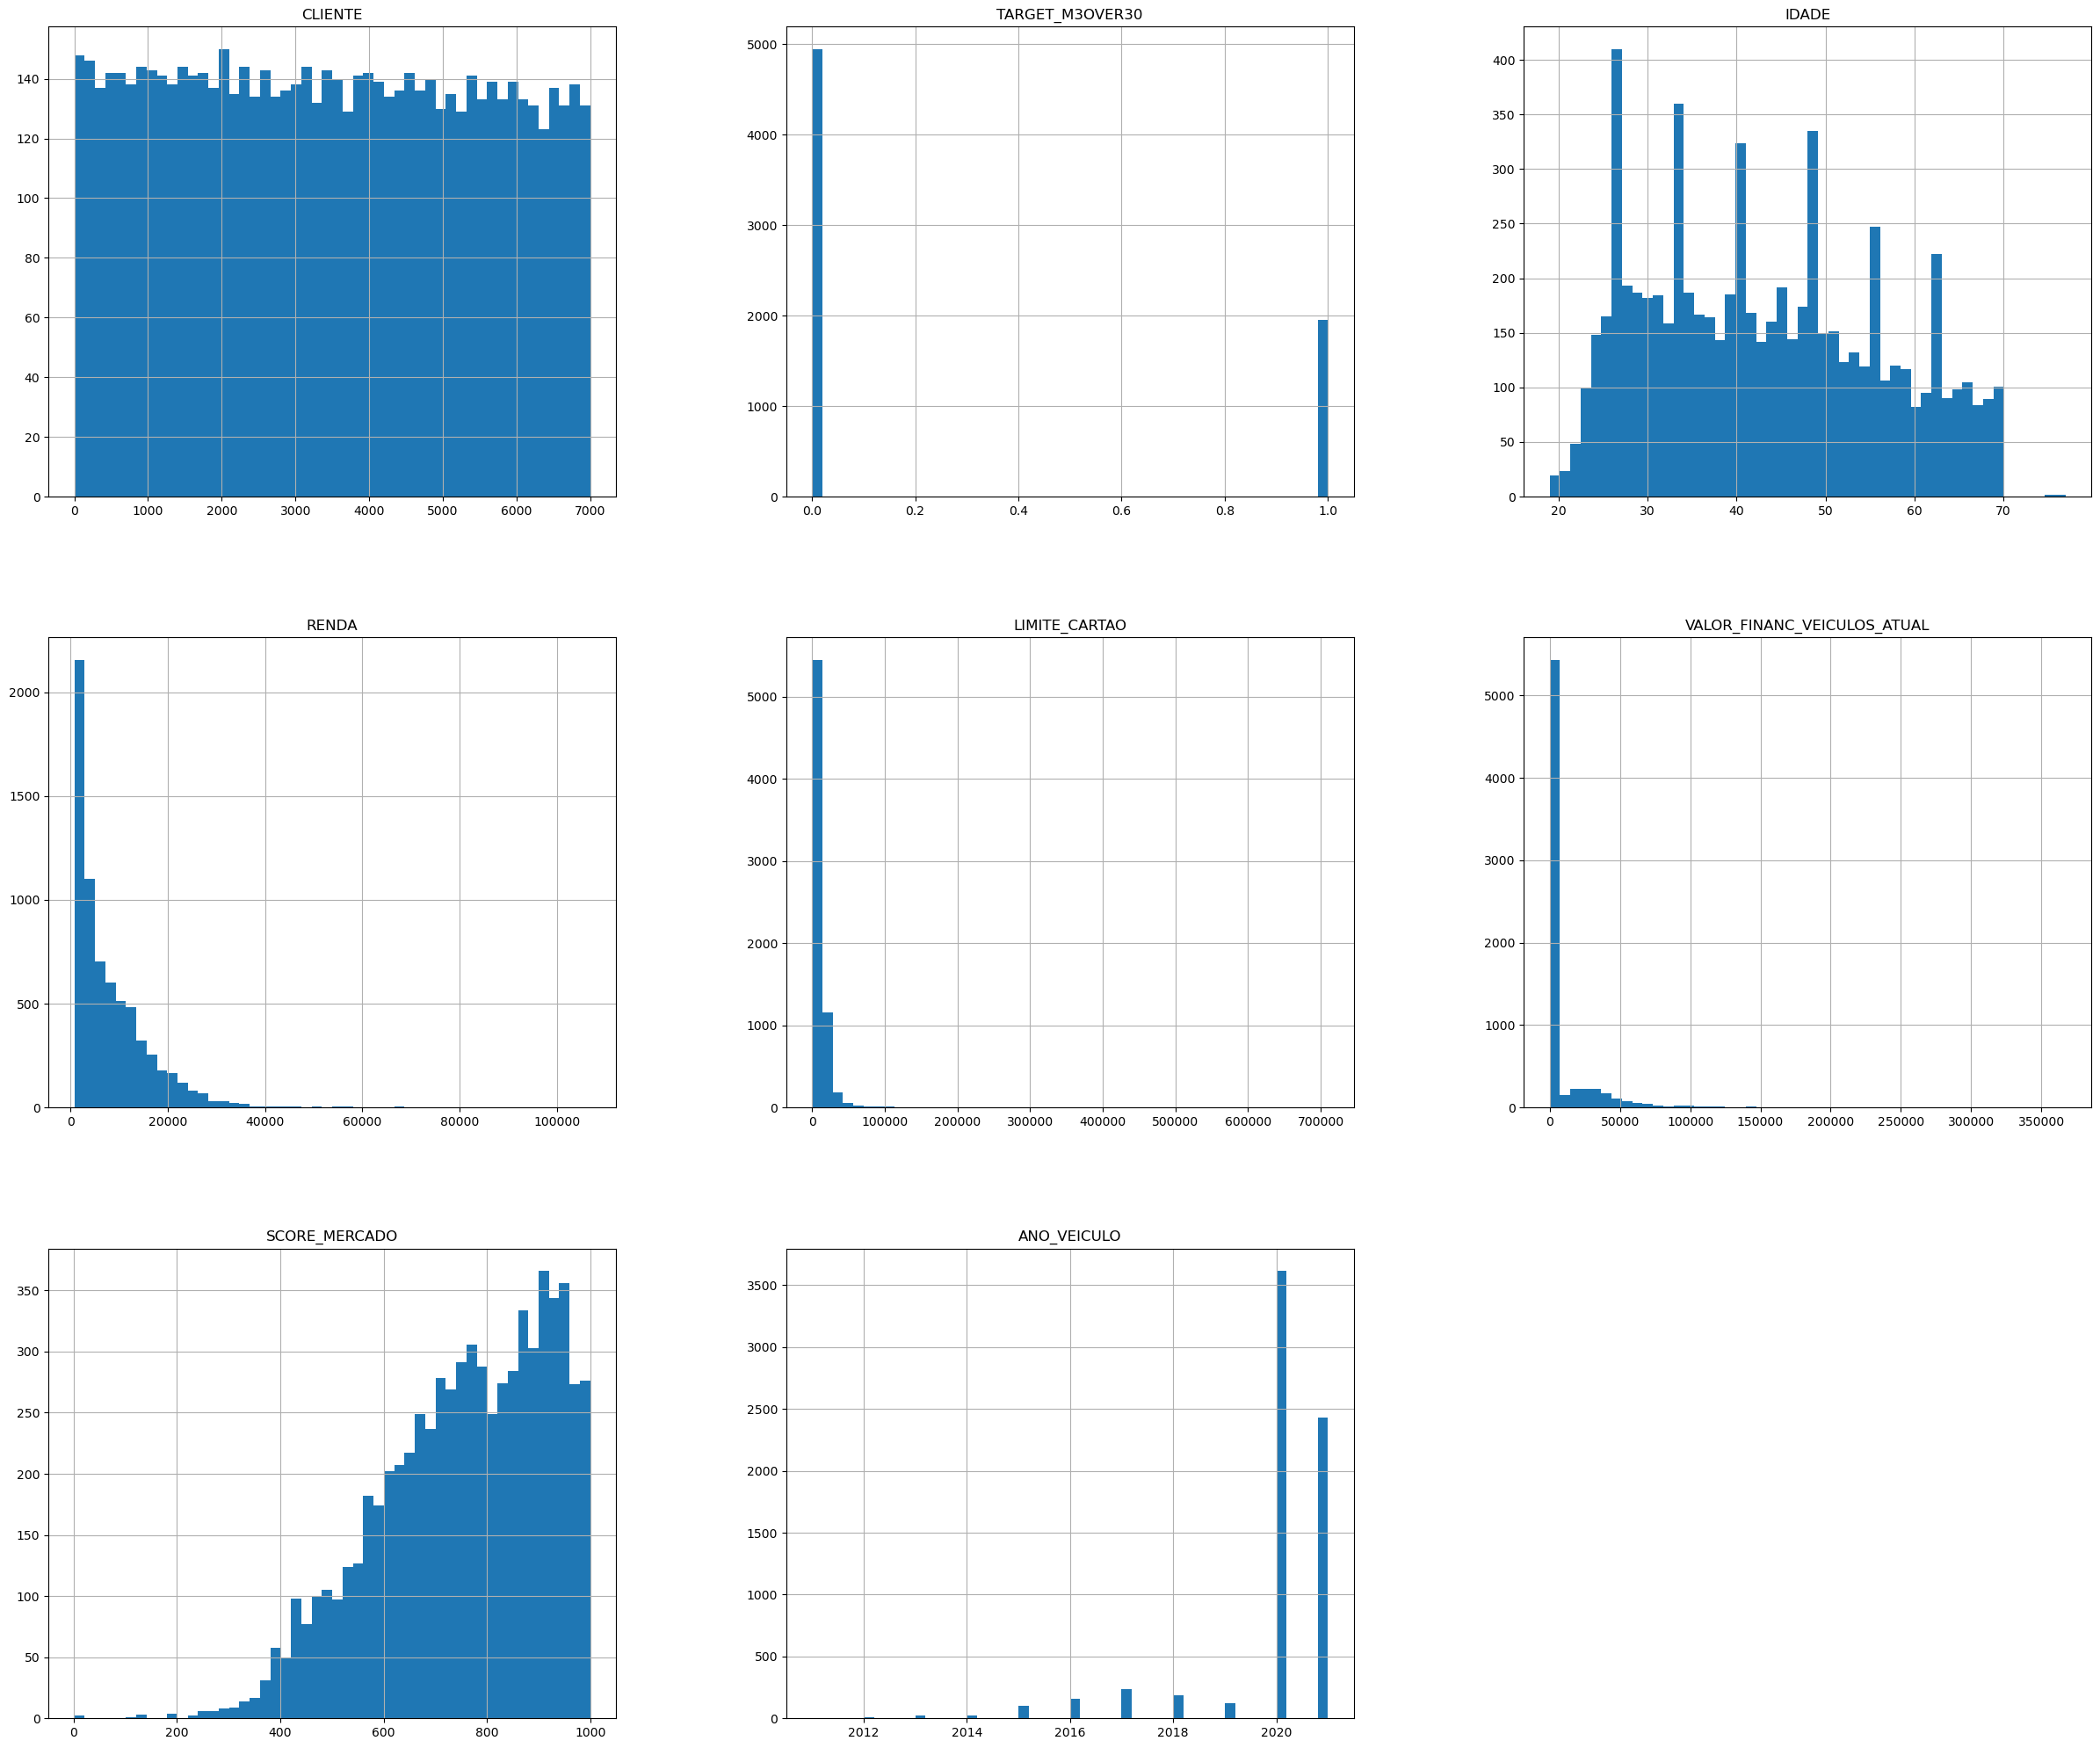

In [10]:
# histograma das variáveis da base de dados 
df.hist(bins=50, figsize=(30, 25))
plt.show()

#### Neste histograma da variável idade, podemos perceber que a maior frequência de clientes é de, aproximadamente, 25 a 30 anos.

c:\Users\samsung\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


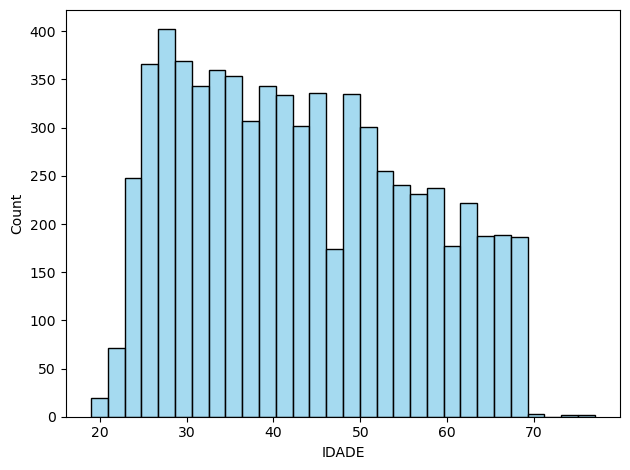

In [11]:
# histograma apenas da idade 
sns.histplot(df['IDADE'], bins=30, kde=False, color='skyblue')  # 30 bins pode ser ajustado
plt.tight_layout()
plt.show()

In [12]:
df['IDADE'].value_counts()

IDADE
27.0    209
26.0    201
28.0    193
45.0    192
33.0    187
29.0    187
35.0    187
39.0    185
31.0    184
30.0    182
47.0    174
48.0    174
34.0    173
42.0    168
36.0    167
41.0    166
25.0    165
37.0    164
49.0    161
44.0    160
32.0    159
40.0    158
51.0    151
50.0    150
24.0    148
46.0    144
38.0    143
43.0    142
53.0    132
56.0    125
52.0    123
55.0    122
58.0    120
54.0    119
59.0    117
62.0    116
63.0    106
57.0    106
66.0    105
23.0    100
69.0     98
65.0     98
61.0     95
64.0     90
68.0     89
67.0     84
60.0     82
22.0     48
21.0     23
20.0     12
19.0      7
70.0      3
75.0      2
76.0      1
77.0      1
Name: count, dtype: int64

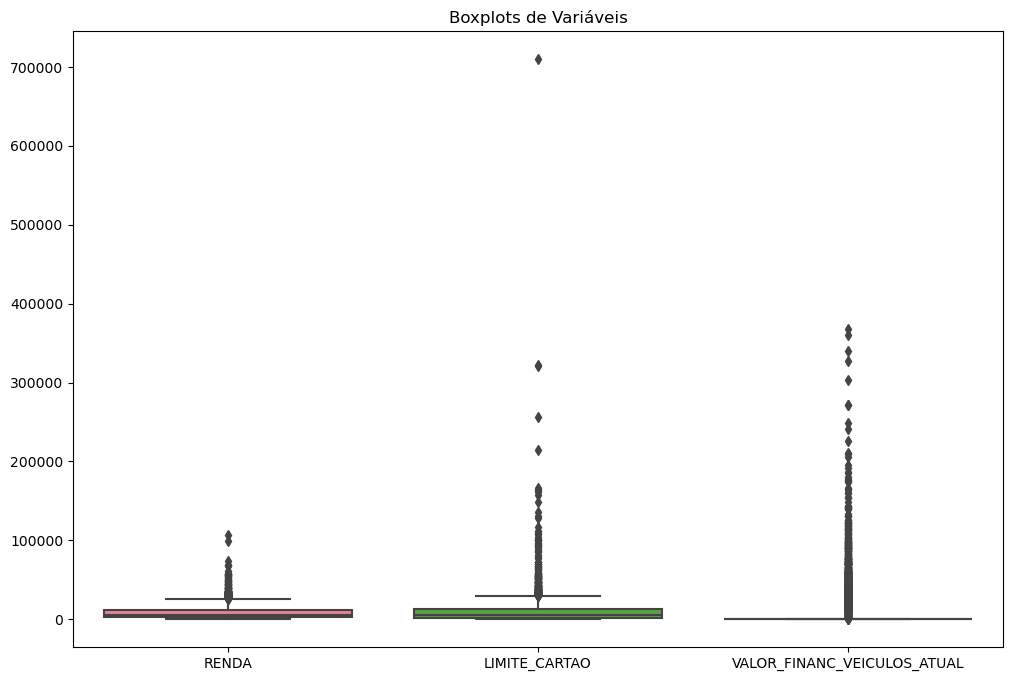

In [13]:
# gráfico boxplot para visualização de variáveis
colunas = ['RENDA', 'LIMITE_CARTAO', 'VALOR_FINANC_VEICULOS_ATUAL', 'VALOR_VEICULO']

plt.figure(figsize=(12, 8))
sns.boxplot(data=df[colunas], palette='husl')
plt.title('Boxplots de Variáveis')
plt.show()

#### Nestes dois boxplots mostro a diferença de quando diminuímos a escala dos valores do eixo y. Podemos perceber que os valores mais comuns de renda e limite de cartão variam de 1000/2000 até 12000/13000, porém, existem outliers nessas duas variáveis. 

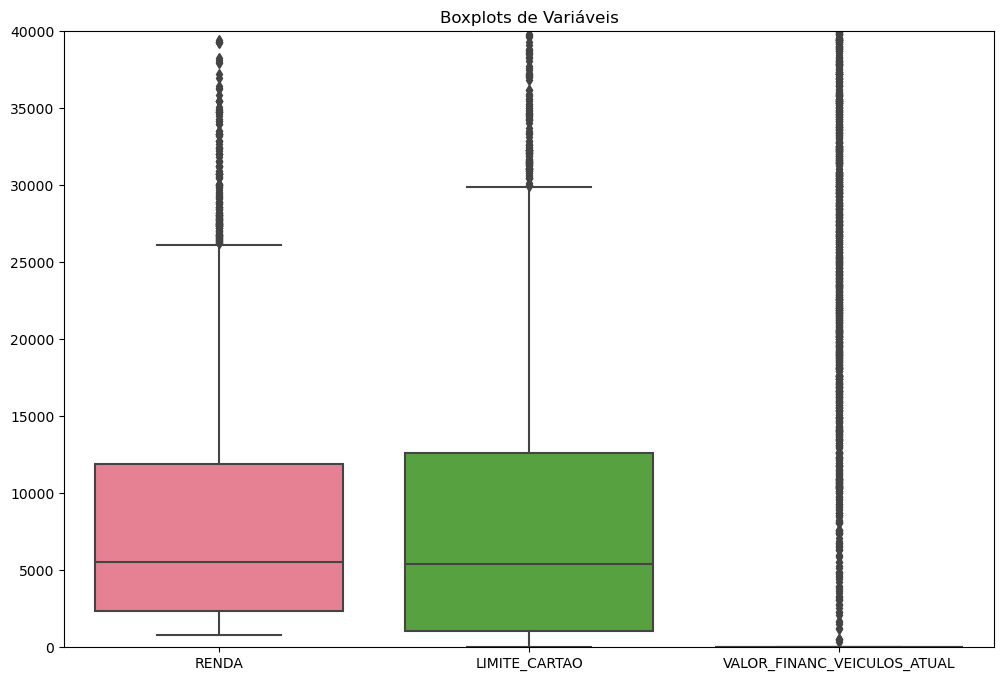

In [14]:
# mesmo boxplot mas com diminuição da escala para melhor visualização
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[colunas], palette='husl')
plt.ylim(0, 40000)
plt.title('Boxplots de Variáveis')
plt.show()

#### Aqui, podemos visualizar que a maior parte do Score dos clientes está acima de 600.

<Axes: >

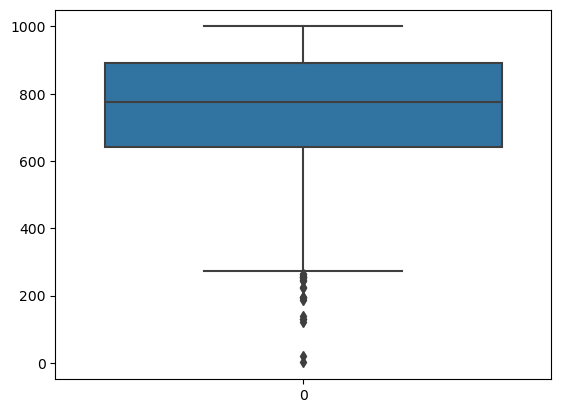

In [15]:
# boxplot da variável Score Mercado
sns.boxplot(data=df['SCORE_MERCADO'])

#### Neste gráfico abaixo, podemos notar que os maiores Scores estão relacionados ao não atraso do financiamento, porém, não é uma regra, pois scores altos também indicam inadimplentes.

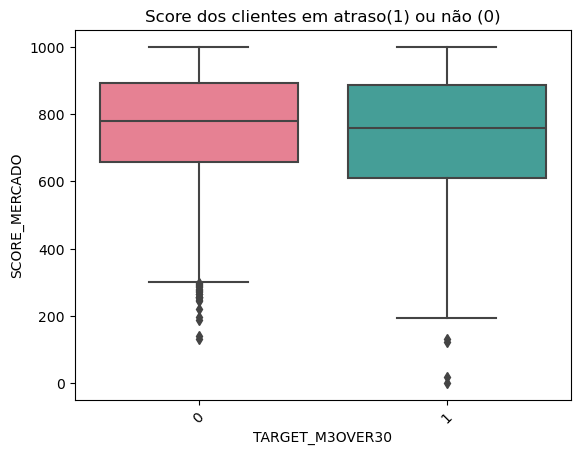

In [16]:
# relação entre score e inadimplência
sns.boxplot(x='TARGET_M3OVER30', y='SCORE_MERCADO', data=df, palette='husl')
plt.title('Score dos clientes em atraso(1) ou não (0)')
plt.xticks(rotation=45)
plt.show()

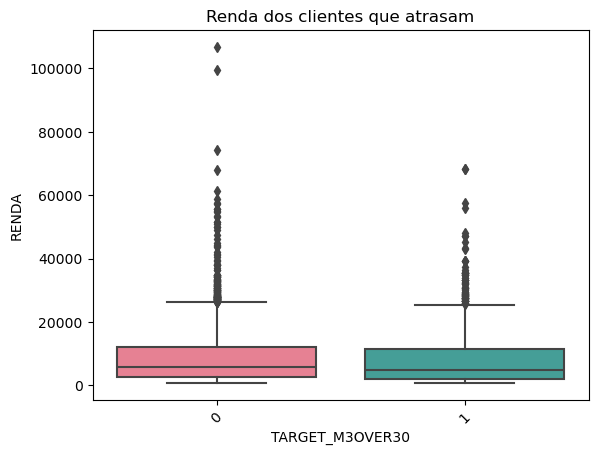

In [17]:
# relação entre a renda dos clientes e a inadimplência
sns.boxplot(x='TARGET_M3OVER30', y='RENDA', data=df, palette='husl')
plt.title('Renda dos clientes que atrasam')
plt.xticks(rotation=45)
plt.show()

#### Neste gráfico abaixo, podemos perceber que o Estado com maior frequência de clientes inadimplentes é o Estado de SP (o qual também apresenta maior número de clientes pagantes)

C:\Users\samsung\AppData\Local\Temp\ipykernel_5212\1760578156.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TARGET_M3OVER30'] = df['TARGET_M3OVER30'].astype(int).astype(str)


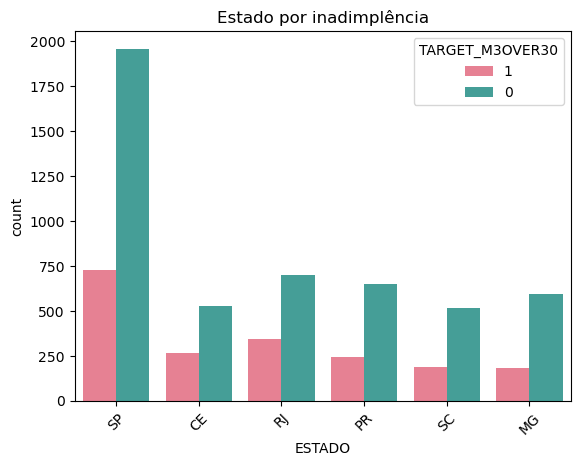

In [18]:
# visualização de Estados que mais atrasam 
df['TARGET_M3OVER30'] = df['TARGET_M3OVER30'].astype(int).astype(str)

sns.countplot(x='ESTADO', hue='TARGET_M3OVER30', data=df, palette='husl')
plt.title('Estado por inadimplência')
plt.xticks(rotation=45)
plt.show()

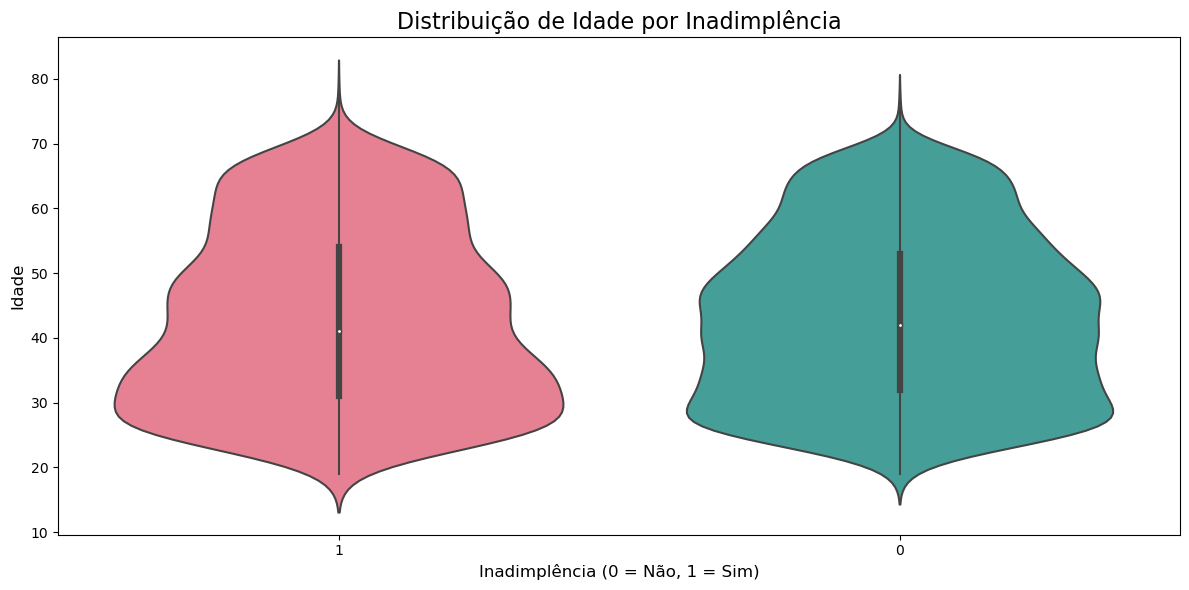

In [19]:
# violin plot das idades que mais atrasam
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='TARGET_M3OVER30', y='IDADE', palette='husl')
plt.title('Distribuição de Idade por Inadimplência', fontsize=16)
plt.xlabel('Inadimplência (0 = Não, 1 = Sim)', fontsize=12)
plt.ylabel('Idade', fontsize=12)
plt.tight_layout()
plt.show()

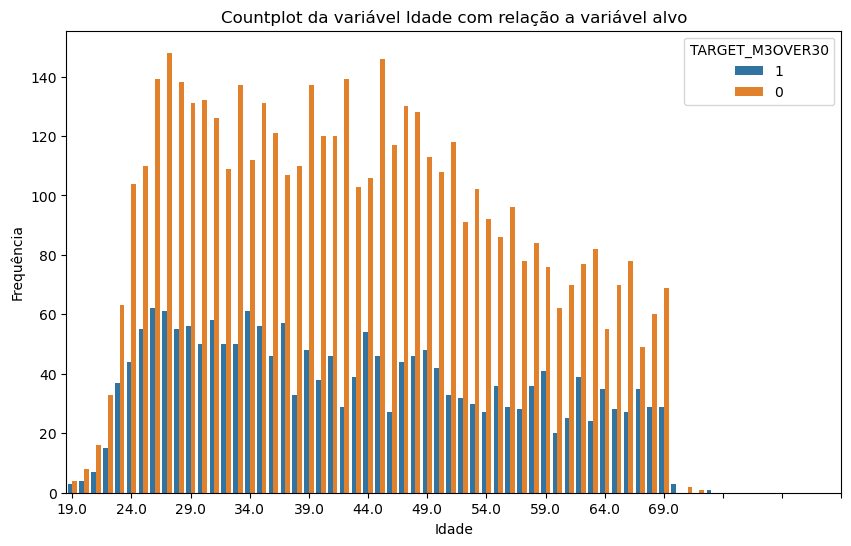

In [20]:
# relação da idade com a inadimplência com outra visualização
plt.figure(figsize=(10,6))
sns.countplot(x='IDADE', hue='TARGET_M3OVER30', data=df)
plt.title("Countplot da variável Idade com relação a variável alvo")
plt.xlabel('Idade')
plt.xticks(np.arange(0, 70, step=5))
plt.ylabel("Frequência")
plt.show()

#### Nos dois gráficos acima, relaciono a idade com a variável alvo. Portanto, o que podemos perceber é que a idade mais comum de clientes inadimplentes é 26, 27 e 34 anos.

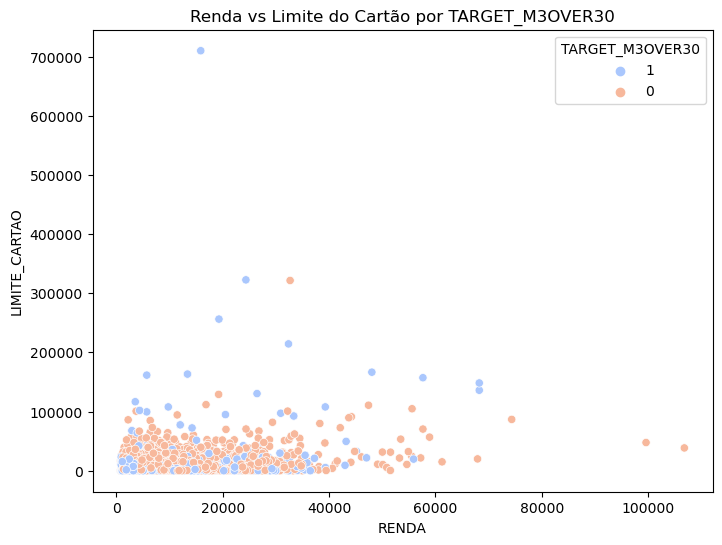

In [21]:
# relação entre renda e limite de cartão com a variável alvo
plt.figure(figsize=(8, 6))
sns.scatterplot(x='RENDA', y='LIMITE_CARTAO', hue='TARGET_M3OVER30', data=df, palette='coolwarm')
plt.title('Renda vs Limite do Cartão por TARGET_M3OVER30')
plt.show()


#### Neste gráfico acima, podemos perceber que valores mais altos de renda e de limite no cartão implicam em possível inadimplência.

In [22]:
# transformando a coluna Data Financiamento para o formato datetime
df['DATA_FINANCIAMENTO'] = pd.to_datetime(df['DATA_FINANCIAMENTO'], errors='coerce')
print(df['DATA_FINANCIAMENTO'].dtype)

datetime64[ns]


C:\Users\samsung\AppData\Local\Temp\ipykernel_5212\3390235252.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DATA_FINANCIAMENTO'] = pd.to_datetime(df['DATA_FINANCIAMENTO'], errors='coerce')


In [23]:
from datetime import datetime

# data atual
hoje = datetime.now()

# calcular a idade do financiamento em meses
df['IDADE_FINANCIAMENTO_MESES'] = ((hoje - df['DATA_FINANCIAMENTO']).dt.days) // 30

# verificando os primeiros registros
print(df[['DATA_FINANCIAMENTO', 'IDADE_FINANCIAMENTO_MESES']].head())

  DATA_FINANCIAMENTO  IDADE_FINANCIAMENTO_MESES
0         2021-10-01                         38
1         2021-11-01                         37
2         2021-10-01                         38
3         2021-12-01                         36
4         2021-12-01                         36


C:\Users\samsung\AppData\Local\Temp\ipykernel_5212\2714241170.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IDADE_FINANCIAMENTO_MESES'] = ((hoje - df['DATA_FINANCIAMENTO']).dt.days) // 30


#### Aqui, criei três novas variáveis para conseguir utilizar a data do financiamento no modelo. Porém, com análises demonstradas a seguir, a quantidade de valores únicos nessas variáveis é muito pequena, então, não foi demonstrado um grande impacto nos modelos. 

In [24]:
# verificar se há valores nulos na coluna
print(df['DATA_FINANCIAMENTO'].isnull().sum())

0


In [25]:
# verificar quantos valores únicos existem na coluna
df['IDADE_FINANCIAMENTO_MESES'].unique()

array([38, 37, 36], dtype=int64)

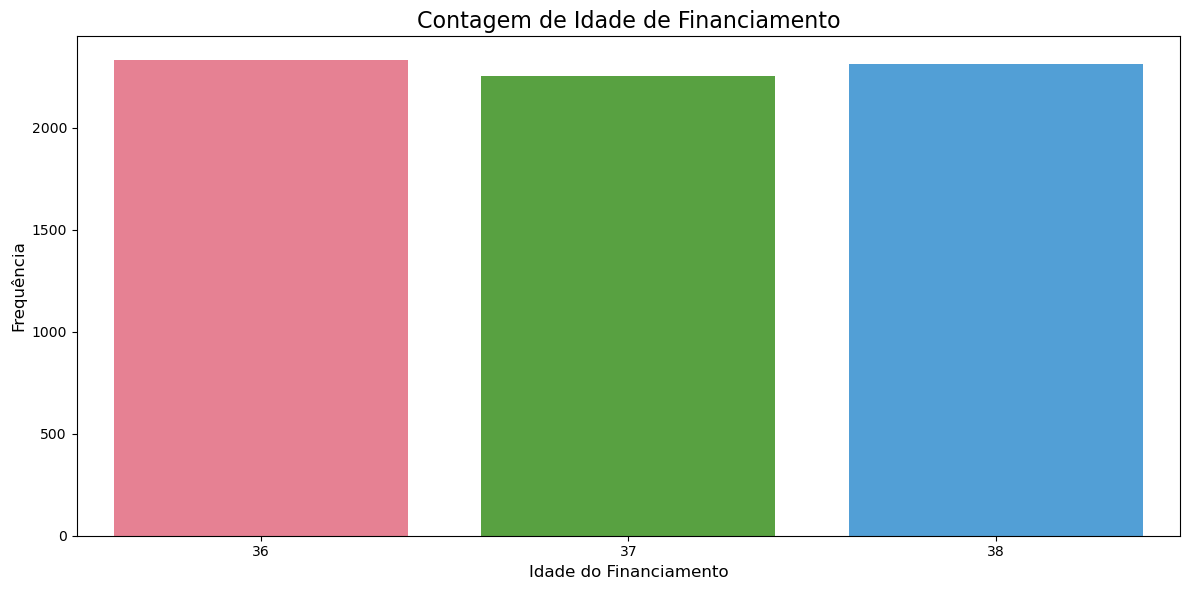

In [26]:
# demonstração de qual tempo de financiamento é mais frequente

freq_finan = df['IDADE_FINANCIAMENTO_MESES'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=freq_finan.index, y=freq_finan.values, palette='husl')
plt.title('Contagem de Idade de Financiamento', fontsize=16)
plt.xlabel('Idade do Financiamento', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.tight_layout()
plt.show()

In [27]:
# extrair o mês e o ano
df['MES_FINANCIAMENTO'] = df['DATA_FINANCIAMENTO'].dt.month
df['ANO_FINANCIAMENTO'] = df['DATA_FINANCIAMENTO'].dt.year

C:\Users\samsung\AppData\Local\Temp\ipykernel_5212\629620234.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MES_FINANCIAMENTO'] = df['DATA_FINANCIAMENTO'].dt.month
C:\Users\samsung\AppData\Local\Temp\ipykernel_5212\629620234.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ANO_FINANCIAMENTO'] = df['DATA_FINANCIAMENTO'].dt.year


In [28]:
# verificar quais anos de financiamento existem na coluna
df['ANO_FINANCIAMENTO'].unique()

array([2021])

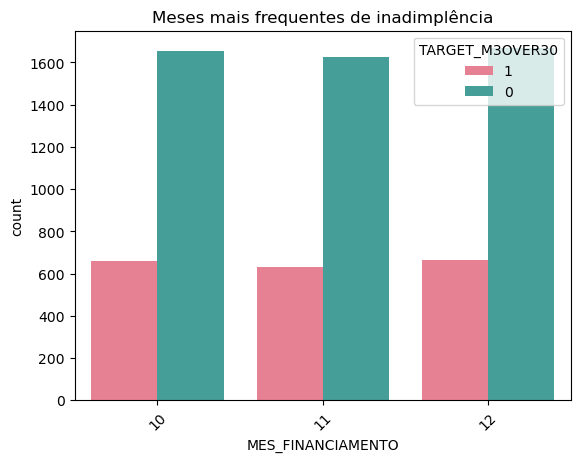

In [29]:
# verificar quais meses a inadimplência é mais frequente
sns.countplot(x='MES_FINANCIAMENTO', hue='TARGET_M3OVER30', data=df, palette='husl')
plt.title('Meses mais frequentes de inadimplência')
plt.xticks(rotation=45)
plt.show()

#### Nessas análises abaixo, resolvi excluir a coluna valor de financiamento de veículos devido à grande quantidade de valores 0.

In [30]:
# análise dos valores da variável Valor de financiamento dos veículos
df['VALOR_FINANC_VEICULOS_ATUAL'].value_counts()

VALOR_FINANC_VEICULOS_ATUAL
0.000000         5378
3288.570000         2
33145.400000        2
30751.499721        1
34530.718165        1
                 ... 
2290.156835         1
60390.231967        1
248429.079279       1
16621.543489        1
44415.298425        1
Name: count, Length: 1519, dtype: int64

In [31]:
# excluir a coluna Valor de Financiamento dos veículos pela quantidade de nulos presente
df = df.drop('VALOR_FINANC_VEICULOS_ATUAL', axis=1)
df

,CLIENTE,DATA_FINANCIAMENTO,TARGET_M3OVER30,IDADE,ESTADO,RENDA,LIMITE_CARTAO,SCORE_MERCADO,VALOR_VEICULO,ANO_VEICULO,IDADE_FINANCIAMENTO_MESES,MES_FINANCIAMENTO,ANO_FINANCIAMENTO
0,0,2021-10-01,1,25.0,SP,4760.043944,21361.878421,882.238536,"27802,51",2020.0,38,10,2021
1,1,2021-11-01,1,27.0,CE,1700.000000,6551.924996,956.692365,"34525,51",2020.0,37,11,2021
2,2,2021-10-01,1,32.0,RJ,4004.147555,12831.296653,610.724337,"36178,14",2020.0,38,10,2021
3,3,2021-12-01,1,39.0,CE,12250.000000,11252.113450,815.069341,"38681,99",2020.0,36,12,2021
4,4,2021-12-01,0,38.0,RJ,1800.000000,11087.609068,947.383539,"30742,18",2021.0,36,12,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,4588,2021-11-01,1,37.0,SC,20728.584790,17490.004917,719.000000,"41896,12",2021.0,37,11,2021
6996,6996,2021-10-01,0,27.0,SP,11780.381806,250.000000,990.681716,"38848,43",2021.0,38,10,2021
6997,6997,2021-10-01,0,24.0,SC,39445.186665,398.000000,885.814411,"43202,45",2020.0,38,10,2021
6998,6998,2021-10-01,0,45.0,SP,4800.000000,18081.477110,850.907405,"34693,58",2021.0,38,10,2021


In [32]:
# verificação da quantidade de valores 0 na coluna Limite Cartão
df['LIMITE_CARTAO'].value_counts()

LIMITE_CARTAO
0.000000        824
300.000000       11
0.010000          9
1200.000000       8
1000.000000       8
               ... 
1612.862924       1
6691.412036       1
1201.848997       1
4124.284435       1
18081.477110      1
Name: count, Length: 5700, dtype: int64

In [33]:
# transformação da coluna Valor Veículo para o tipo float
df['VALOR_VEICULO'] = df['VALOR_VEICULO'].str.replace(',', '.').astype(float)
 

In [34]:
# verificação
df['VALOR_VEICULO']

0       27802.51
1       34525.51
2       36178.14
3       38681.99
4       30742.18
          ...   
6995    41896.12
6996    38848.43
6997    43202.45
6998    34693.58
6999    31147.91
Name: VALOR_VEICULO, Length: 6898, dtype: float64

In [35]:
# verificando uma possível correlação entre as variáveis
df[['RENDA', 'LIMITE_CARTAO', 'SCORE_MERCADO', 'VALOR_VEICULO']].corr()

,RENDA,LIMITE_CARTAO,SCORE_MERCADO,VALOR_VEICULO
RENDA,1.000000,0.200665,0.014408,0.059969
LIMITE_CARTAO,0.200665,1.000000,0.063642,0.063262
SCORE_MERCADO,0.014408,0.063642,1.000000,0.000654
VALOR_VEICULO,0.059969,0.063262,0.000654,1.000000


#### Quando analisamos a correlação entre as variáveis, percebemos que os valores são muito baixos. As únicas variáveis que apresentam um valor baixo, porém, um pouco maior de correlação são: Renda e Limite de Cartão (as duas variáveis mais importantes para o modelo, veremos isso mais abaixo)

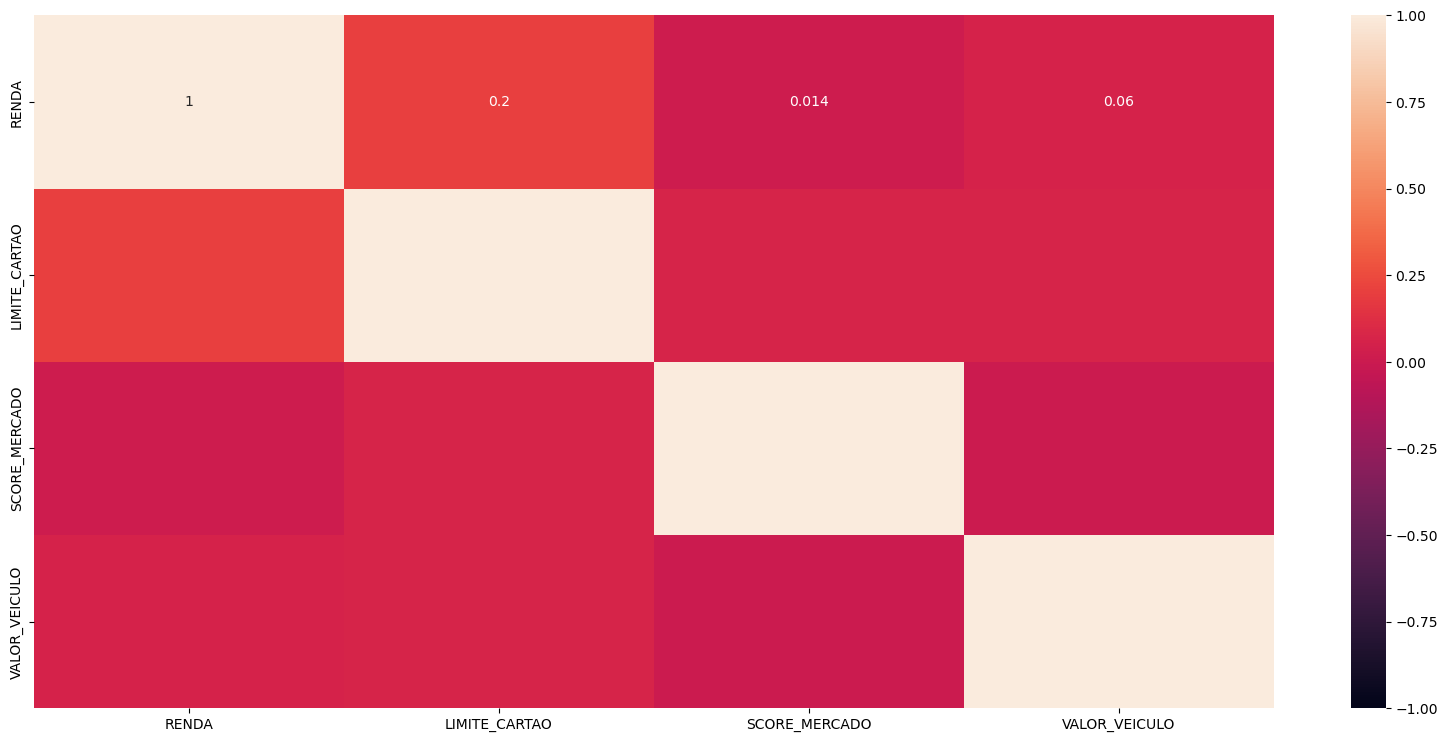

In [36]:
# mapa de calor da correlação entre as variáveis
df_discrete = df[['RENDA', 'LIMITE_CARTAO', 'SCORE_MERCADO', 'VALOR_VEICULO']]
plt.figure(figsize=(20, 9))
heatmap = sns.heatmap(df_discrete.corr().abs(), 
                      vmin=-1, 
                      vmax=1, 
                      annot=True)

In [37]:
# verificando a quantidade de Estados que aparecem no dataframe
print(df['ESTADO'].unique())


['SP' 'CE' 'RJ' 'PR' 'SC' 'MG']


In [38]:
# usando o LabelEncoder para transformar a coluna Estado
encoder = LabelEncoder()
df['ESTADO_ENCODED'] = encoder.fit_transform(df['ESTADO'])


In [39]:
# verificar quais números foram atribuídos para cada Estado
print(df[['ESTADO', 'ESTADO_ENCODED']].head(10))

  ESTADO  ESTADO_ENCODED
0     SP               5
1     CE               0
2     RJ               3
3     CE               0
4     RJ               3
5     SP               5
6     PR               2
7     RJ               3
8     SP               5
9     SC               4


In [40]:
# transformando novamente a variável alvo em int
df['TARGET_M3OVER30'] = df['TARGET_M3OVER30'].astype(int)


In [41]:
# contagem de valores das classes da variável alvo para verificar o desbalanceamento 
print(f"A base de dados possui {df[df['TARGET_M3OVER30']==0].shape[0]} registros com classe 0 e {df[df['TARGET_M3OVER30']==1].shape[0]} na classe 1")
print(f"Porcentagem de dados na classe 0: {np.round(df[df['TARGET_M3OVER30']==0].shape[0]/(df.shape[0]),2)}")
print(f"Porcentagem de dados na classe 1: {np.round(df[df['TARGET_M3OVER30']==1].shape[0]/(df.shape[0]),2)}")

A base de dados possui 4944 registros com classe 0 e 1954 na classe 1
Porcentagem de dados na classe 0: 0.72
Porcentagem de dados na classe 1: 0.28


## 2 - Treinamento e Teste

In [42]:
# definindo valores de X e y
X = df[['IDADE', 'RENDA', 'LIMITE_CARTAO', 'SCORE_MERCADO', 'VALOR_VEICULO', 'ESTADO_ENCODED']]
y = df['TARGET_M3OVER30']

In [43]:
# análise estatística da variável X
X.describe()

,IDADE,RENDA,LIMITE_CARTAO,SCORE_MERCADO,VALOR_VEICULO,ESTADO_ENCODED
count,6898.000000,6898.000000,6898.000000,6898.000000,6898.000000,6898.000000
mean,43.115251,8238.090355,9027.895528,754.572105,40131.138388,3.183097
std,13.021799,7949.645174,16065.667970,163.730261,7465.196000,1.799576
min,19.000000,800.000000,0.000000,1.462154,16108.130000,0.000000
25%,32.000000,2350.000000,1058.153346,641.000000,34979.967500,2.000000
50%,42.000000,5550.000000,5422.618532,775.000000,39771.355000,3.000000
75%,53.000000,11875.311412,12592.439606,891.072137,44714.402500,5.000000
max,77.000000,106828.787747,709776.920000,999.999903,97177.920000,5.000000


In [44]:
# treinamento dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Devido à presença de outliers nas variáveis, resolvi padronizar os dados para todos ficarem na mesma escala e serem tratados da mesma maneira.

In [45]:
# padronização dos dados usando StandardScaler
scaler = StandardScaler()

# ajuste e transformação dos dados de treino
X_train_scaled = scaler.fit_transform(X_train)

# transformação dos dados de teste 
X_test_scaled = scaler.transform(X_test)

In [46]:
# verificar as primeiras linhas dos dados padronizados
print(X_train_scaled[:5])

[[ 1.06823744  0.77140969  0.50759709  0.3602222   0.66330944  1.00394026]
 [-1.00619359 -0.87944556 -0.63174707  0.84387577 -0.64345338  0.44690231]
 [ 0.76091432  0.02510227 -0.59630487 -0.14777644 -1.77473596 -1.78124945]
 [-1.08302437  0.17700106  0.80392797  0.41543606  0.81415332  1.00394026]
 [ 1.14506822  0.35243157 -0.45757185  1.4444894   0.41873966  1.00394026]]


## 3 - Modelos 

### 3.1 - Regressão Logística

In [47]:
# instanciando e iniciando o modelo de Regressão Logística
logreg = LogisticRegression(random_state=42, class_weight='balanced', max_iter=2000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

In [48]:
# primeira análise do desempenho do modelo
print("Avaliação da Regressão Logística:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_logreg):.4f}")
print(f"Matriz de Confusão:\n{confusion_matrix(y_test, y_pred_logreg)}")
print(f"Relatório de Classificação:\n{classification_report(y_test, y_pred_logreg)}")

Avaliação da Regressão Logística:
Acurácia: 0.5420
Matriz de Confusão:
[[576 423]
 [209 172]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.73      0.58      0.65       999
           1       0.29      0.45      0.35       381

    accuracy                           0.54      1380
   macro avg       0.51      0.51      0.50      1380
weighted avg       0.61      0.54      0.56      1380



In [49]:
# criação de pipeline para SMOTE e modelo de regressão logística
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),  # Aplica SMOTE no conjunto de treinamento
    ('logreg', LogisticRegression(random_state=42))
])

# hiperparâmetros para otimização
param_grid = {
    'logreg__C': [0.1, 1, 10, 50, 100], 
    'logreg__penalty': ['l2'],
    'logreg__solver': ['liblinear', 'saga']
}

# Grid Search com validação cruzada
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='recall',  
    cv=5,  
    verbose=1,
    n_jobs=-1
)

# ajustar ao conjunto de treinamento
grid_search.fit(X_train, y_train)
print("Melhores parâmetros:", grid_search.best_params_)

# melhor modelo encontrado pelo Grid Search
best_logreg = grid_search.best_estimator_

# previsões no conjunto de teste
y_pred_logreg = best_logreg.predict(X_test)

# avaliação
print("Classification Report:")
print(classification_report(y_test, y_pred_logreg))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))

print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg):.4f}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhores parâmetros: {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'saga'}
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.52      0.61       999
           1       0.30      0.55      0.39       381

    accuracy                           0.53      1380
   macro avg       0.53      0.54      0.50      1380
weighted avg       0.63      0.53      0.55      1380

Confusion Matrix:
[[519 480]
 [171 210]]
Accuracy: 0.5283


c:\Users\samsung\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### Neste modelo de Regressão Logística, após a otimização de parâmetros com o SMOTE, o desempenho teve uma melhora em quase todas as métricas, porém, resolvi testar outros modelos para analisar em qual iria aprofundar a otimização.

### 3.2 - Árvore de Decisão

In [50]:
# instanciando e iniciando o modelo de Árvore de Decisão
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

In [51]:
# avaliação do modelo
print("Avaliação da Árvore de Decisão:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_tree):.4f}")
print(f"Matriz de Confusão:\n{confusion_matrix(y_test, y_pred_tree)}")
print(f"Relatório de Classificação:\n{classification_report(y_test, y_pred_tree)}")

Avaliação da Árvore de Decisão:
Acurácia: 0.6304
Matriz de Confusão:
[[736 263]
 [247 134]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.75      0.74      0.74       999
           1       0.34      0.35      0.34       381

    accuracy                           0.63      1380
   macro avg       0.54      0.54      0.54      1380
weighted avg       0.64      0.63      0.63      1380



#### No modelo de Árvore de Decisão, o recall, precision e f1-score ficaram muito baixos na classe 1 (sem otimização), por isso, resolvi focar em outros modelos. 

### 3.3 - Random Forest

In [52]:
# instanciando e iniciando o modelo de Random Forest
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=200, max_depth=10)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [53]:
# avaliação do modelo
print("Avaliação do Random Forest:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Matriz de Confusão:\n{confusion_matrix(y_test, y_pred_rf)}")
print(f"Relatório de Classificação:\n{classification_report(y_test, y_pred_rf)}")

Avaliação do Random Forest:
Acurácia: 0.7109
Matriz de Confusão:
[[874 125]
 [274 107]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       999
           1       0.46      0.28      0.35       381

    accuracy                           0.71      1380
   macro avg       0.61      0.58      0.58      1380
weighted avg       0.68      0.71      0.69      1380



#### Aqui, o recall está muito baixo, pois o modelo está com dificuldades para classificar a classe 1. Portanto, resolvi aprofundar na otimização desse modelo devido à alta acurácia apresentada.

#### Abaixo, plotei as variáveis mais importantes, e como visto na análise exploratória, Limite de Cartão e Renda são as mais impactantes para o modelo.

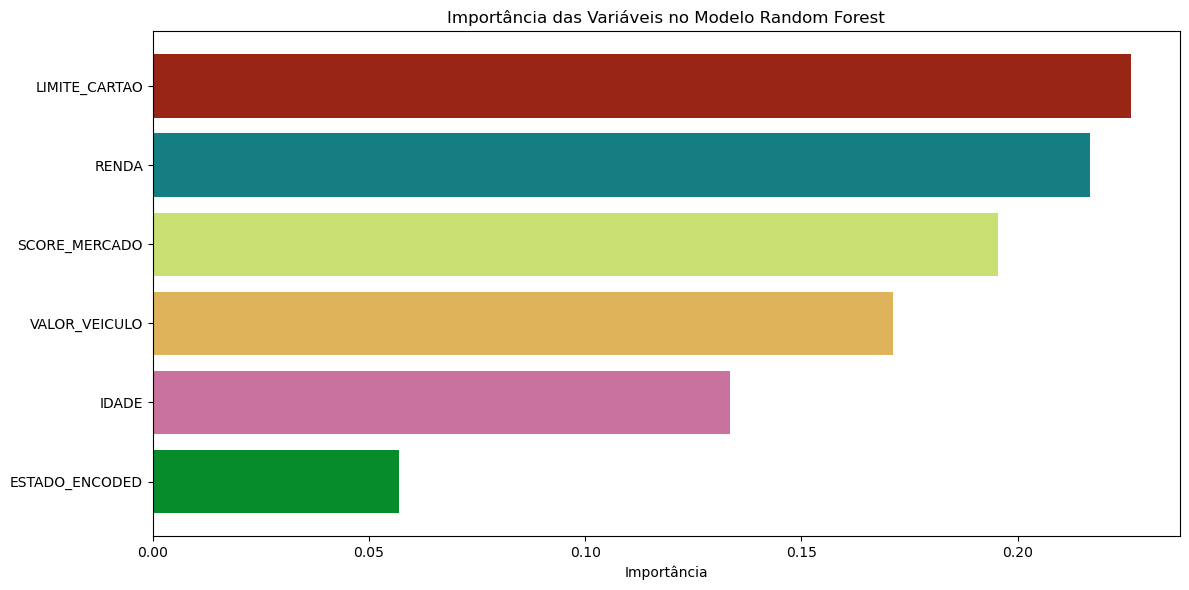

In [54]:
# obtendo a importância das variáveis
importances = rf.feature_importances_
indices = importances.argsort()

colors = np.random.rand(len(importances), 3)

plt.figure(figsize=(12, 6))
plt.barh(X_train.columns[indices], importances[indices], color=colors)
plt.xlabel('Importância')
plt.title('Importância das Variáveis no Modelo Random Forest')
plt.tight_layout()
plt.show()

In [55]:
# criar pipeline com SMOTE e RandomForest
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),  # Aplica SMOTE no conjunto de treinamento
    ('model', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# treinamento
pipeline.fit(X_train, y_train)

# obter as probabilidades preditas na classe 1
y_proba_smote = pipeline.predict_proba(X_test)[:, 1]

# ajuste do limiar para maximizar o recall
custom_threshold = 0.3
y_pred_smote_custom = (y_proba_smote >= custom_threshold).astype(int)

# avaliação
print("Avaliação com limiar ajustado:")
print(f"Acurácia com SMOTE: {accuracy_score(y_test, y_pred_smote_custom):.4f}")
print(f"Recall com SMOTE: {recall_score(y_test, y_pred_smote_custom):.4f}")
print(f"Matriz de Confusão com SMOTE:\n{confusion_matrix(y_test, y_pred_smote_custom)}")

Avaliação com limiar ajustado:
Acurácia com SMOTE: 0.4565
Recall com SMOTE: 0.8136
Matriz de Confusão com SMOTE:
[[320 679]
 [ 71 310]]


#### Com o SMOTE e analisando a matriz de confusão através do ajuste do limiar, o recall subiu para 0.81, o que é um valor ótimo se olhássemos somente para essa métrica de avaliação. Porém, ao analisarmos o classification report abaixo com os parâmetros otimizados, observamos uma melhora, mas não uma melhora ideal.

In [56]:
# definir o grid de parâmetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', None]
}

# GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                           param_grid=param_grid, 
                           cv=5, scoring='recall', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# resultados
print("Melhores parâmetros:", grid_search.best_params_)
print(f"Melhor recall: {grid_search.best_score_}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Melhores parâmetros: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}
Melhor recall: 0.43610555050045496


In [57]:
# usando os melhores parâmetros encontrados pelo GridSearchCV
best_rf_model = RandomForestClassifier(
    class_weight='balanced', 
    max_depth=5, 
    min_samples_split=10, 
    n_estimators=100,
    random_state=42
)

# treinando o modelo com os melhores parâmetros
best_rf_model.fit(X_train, y_train)

# previsões e avaliação do modelo
y_pred_rf_best = best_rf_model.predict(X_test)
print(f"Acurácia: {accuracy_score(y_test, y_pred_rf_best):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf_best):.4f}")
print(f"Matriz de Confusão:\n{confusion_matrix(y_test, y_pred_rf_best)}")
print(f"Relatório de Classificação:\n{classification_report(y_test, y_pred_rf_best)}")


Acurácia: 0.6833
Recall: 0.4121
Matriz de Confusão:
[[786 213]
 [224 157]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.78      0.79      0.78       999
           1       0.42      0.41      0.42       381

    accuracy                           0.68      1380
   macro avg       0.60      0.60      0.60      1380
weighted avg       0.68      0.68      0.68      1380



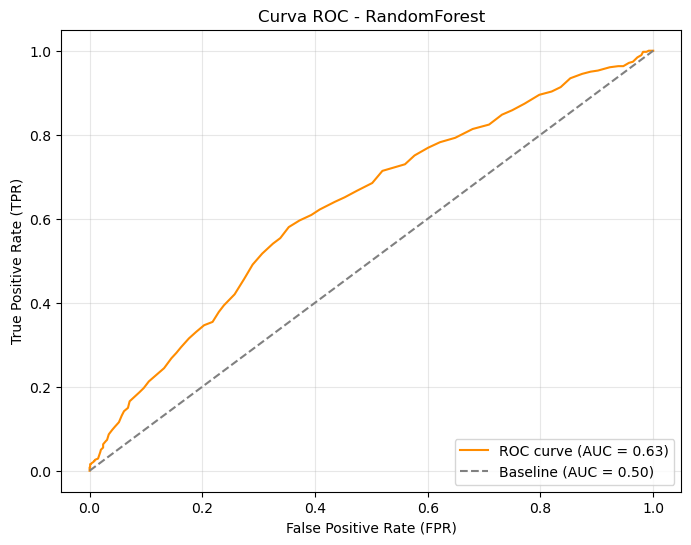

AUC: 0.6303


In [58]:
# calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_smote)
roc_auc = roc_auc_score(y_test, y_proba_smote)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Baseline (AUC = 0.50)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curva ROC - RandomForest')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# imprimir o AUC
print(f"AUC: {roc_auc:.4f}")

#### Após realizar o ajuste de hiperparâmetros o recall aumentou de 0.28 para 0.41. Ao analisar a curva ROC AUC com o valor de 0.63, isso indica que o modelo tem um desempenho moderado, mas ainda toma muitas decisões de forma aleatória. O recall aumentou, mas ainda não é o ideal. 

### 3.4 - XGBoost

In [59]:
# instanciando e iniciando o modelo XGBoost
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb_model = XGBClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    objective='binary:logistic')  

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [60]:
# avaliação
print("Avaliação do XGBoost:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Matriz de Confusão:\n{confusion_matrix(y_test, y_pred_xgb)}")
print(f"Relatório de Classificação:\n{classification_report(y_test, y_pred_xgb)}")

Avaliação do XGBoost:
Acurácia: 0.6717
Matriz de Confusão:
[[788 211]
 [242 139]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       999
           1       0.40      0.36      0.38       381

    accuracy                           0.67      1380
   macro avg       0.58      0.58      0.58      1380
weighted avg       0.66      0.67      0.67      1380



#### Aqui, o XGBoost já apresenta um valor melhor de recall logo na primeira avaliação sem otimização. 

In [61]:
# hiperparâmetros para otimizar
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'min_child_weight': [1, 5, 10]
}

# Grid Search com validação cruzada
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='recall', 
    cv=5,
    verbose=1,
    n_jobs=-1
)

# ajustar ao conjunto de treinamento
grid_search.fit(X_train, y_train)

# resultados
print("Melhores hiperparâmetros:", grid_search.best_params_)
print("Melhor recall:", grid_search.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Melhores hiperparâmetros: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 200}
Melhor recall: 0.5104923667980993


In [62]:
# melhor modelo encontrado pelo Grid Search
best_model = grid_search.best_estimator_

# previsões no conjunto de teste
y_test_pred = best_model.predict(X_test)
y_test_prob = best_model.predict_proba(X_test)[:, 1]  

In [63]:

# avaliação no conjunto de teste otimizado
print("Avaliação do modelo otimizado:")
print(f"Acurácia: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"Matriz de Confusão:\n{confusion_matrix(y_test, y_test_pred)}")
print(f"Relatório de Classificação:\n{classification_report(y_test, y_test_pred)}")


Avaliação do modelo otimizado:
Acurácia: 0.6471
Recall: 0.4541
Matriz de Confusão:
[[720 279]
 [208 173]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       999
           1       0.38      0.45      0.42       381

    accuracy                           0.65      1380
   macro avg       0.58      0.59      0.58      1380
weighted avg       0.67      0.65      0.66      1380



#### Com a otimização, o recall aumentou de 0.36 para 0.45.

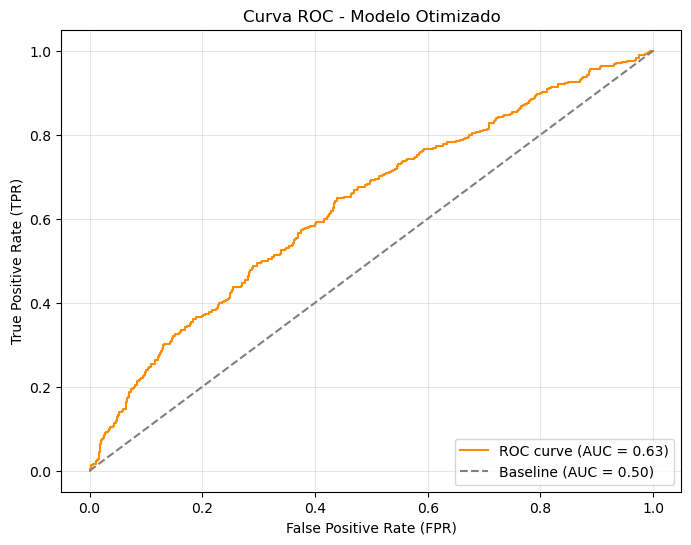

In [64]:
# calcular AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Baseline (AUC = 0.50)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curva ROC - Modelo Otimizado')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [65]:
# probabilidades previstas
y_proba = xgb_model.predict_proba(X_test)[:, 1]

# ajustar o threshold 
threshold = 0.3
y_test_pred_custom = (y_proba >= threshold).astype(int)

# avaliar o modelo com o novo threshold
print("Avaliação com Threshold Ajustado:")
print(confusion_matrix(y_test, y_test_pred_custom))
print(classification_report(y_test, y_test_pred_custom))

Avaliação com Threshold Ajustado:
[[491 508]
 [124 257]]
              precision    recall  f1-score   support

           0       0.80      0.49      0.61       999
           1       0.34      0.67      0.45       381

    accuracy                           0.54      1380
   macro avg       0.57      0.58      0.53      1380
weighted avg       0.67      0.54      0.56      1380



#### Com a definição do melhor threshold, o modelo apresenta um recall bem melhor.

In [66]:
# criar um objeto explainer
explainer = shap.TreeExplainer(best_model)

# calcular os SHAP values para o conjunto de teste
shap_values = explainer.shap_values(X_test)

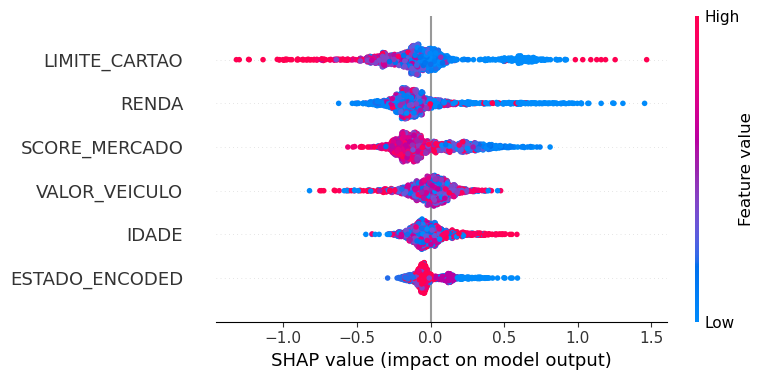

In [67]:
shap.summary_plot(shap_values, X_test)

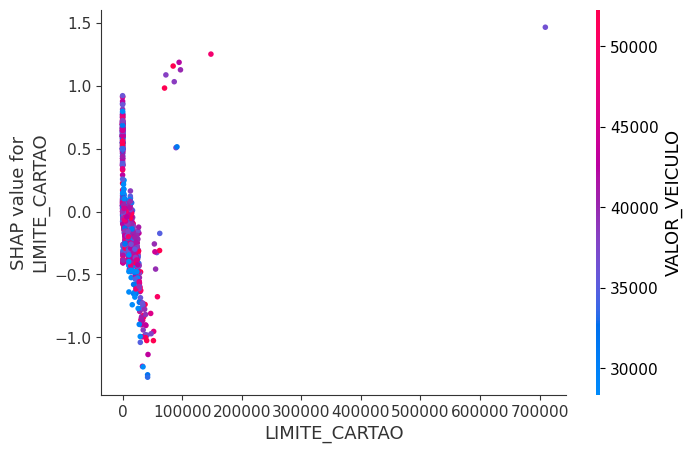

In [68]:
shap.dependence_plot("LIMITE_CARTAO", shap_values, X_test)


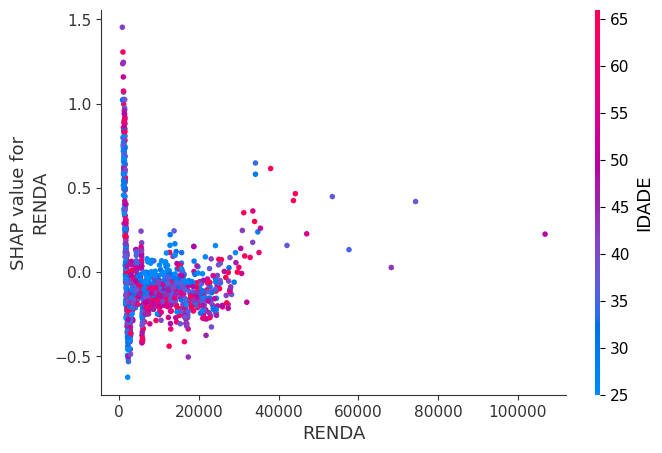

In [69]:
shap.dependence_plot("RENDA", shap_values, X_test)


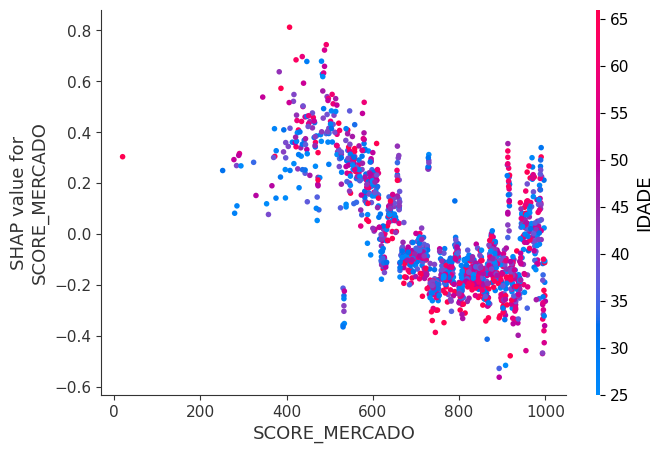

In [70]:
shap.dependence_plot("SCORE_MERCADO", shap_values, X_test)


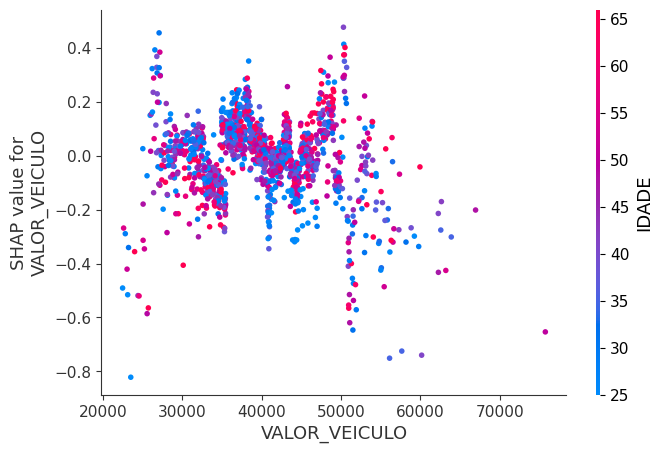

In [71]:
shap.dependence_plot("VALOR_VEICULO", shap_values, X_test)


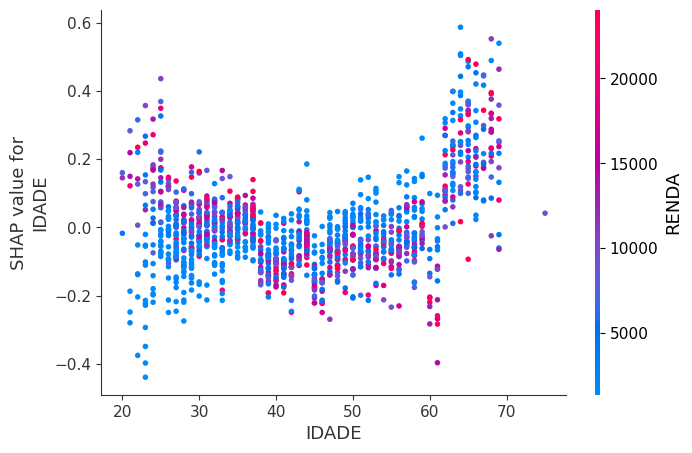

In [72]:
shap.dependence_plot("IDADE", shap_values, X_test)


#### Esses são gráficos que representam a importância das variáveis para o modelo XGBoost, quando mais escura a cor, mais importante é a variável (em relação à outra em gráficos de dependência).

### 3.5 - Light GBM

In [73]:
# instanciando e iniciando o modelo
lgb_model = lgb.LGBMClassifier(random_state=42, class_weight='balanced')
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

[LightGBM] [Info] Number of positive: 1573, number of negative: 3945
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1080
[LightGBM] [Info] Number of data points in the train set: 5518, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


In [74]:
# avaliação
print("Avaliação do LightGBM:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_lgb):.4f}")
print(f"Matriz de Confusão:\n{confusion_matrix(y_test, y_pred_lgb)}")
print(f"Relatório de Classificação:\n{classification_report(y_test, y_pred_lgb)}")

Avaliação do LightGBM:
Acurácia: 0.6609
Matriz de Confusão:
[[759 240]
 [228 153]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.77      0.76      0.76       999
           1       0.39      0.40      0.40       381

    accuracy                           0.66      1380
   macro avg       0.58      0.58      0.58      1380
weighted avg       0.66      0.66      0.66      1380



#### Esse foi o modelo que apresentou melhor valor de recall na primeira avaliação. 

In [75]:
# parâmetros para o Grid Search
param_grid = {
    'num_leaves': [10, 20, 30],
    'min_child_samples': [10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200]
}

# Grid Search com validação cruzada
grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,  
    verbose=1,  
    n_jobs=-1   
)

# ajustar ao conjunto de treinamento
grid_search.fit(X_train, y_train)

# melhor combinação de hiperparâmetros
print("Melhores hiperparâmetros:", grid_search.best_params_)
print("Melhor AUC-ROC:", grid_search.best_score_)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[LightGBM] [Info] Number of positive: 1573, number of negative: 3945
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1080
[LightGBM] [Info] Number of data points in the train set: 5518, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Melhores hiperparâmetros: {'learning_rate': 0.01, 'max_depth': 7, 'min_child_samples': 10, 'n_estimators': 200, 'num_leaves': 10}
Melhor AUC-ROC: 0.62545186897128


In [76]:
# Avaliar no conjunto de teste
best_model_lgb = grid_search.best_estimator_
y_pred = best_model_lgb.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[762 237]
 [214 167]]
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       999
           1       0.41      0.44      0.43       381

    accuracy                           0.67      1380
   macro avg       0.60      0.60      0.60      1380
weighted avg       0.68      0.67      0.68      1380



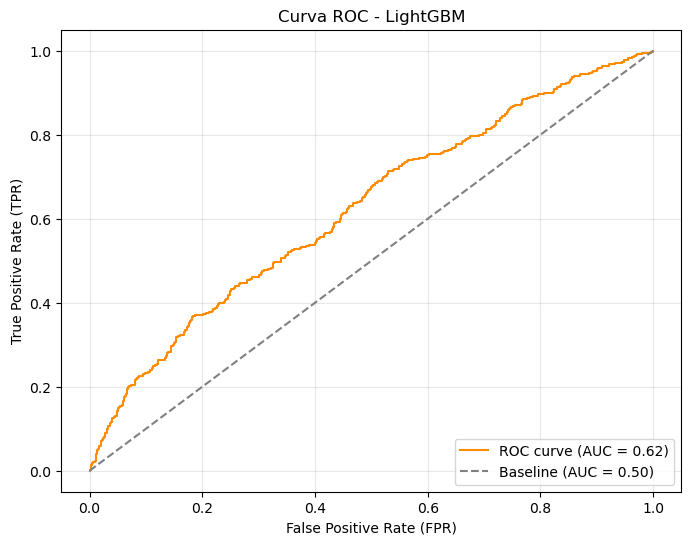

AUC: 0.6233


In [77]:
# obter as probabilidades preditas na classe 1
y_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]  

# calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lgb)

# calcular o AUC
roc_auc = roc_auc_score(y_test, y_proba_lgb)

# plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Baseline (AUC = 0.50)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Curva ROC - LightGBM')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# imprimir o AUC
print(f"AUC: {roc_auc:.4f}")


In [78]:
# probabilidades previstas
y_proba = lgb_model.predict_proba(X_test)[:, 1]

# ajustar o threshold 
threshold = 0.4
y_pred_custom = (y_proba >= threshold).astype(int)

# avaliar o modelo com o novo threshold
print("Avaliação com Threshold Ajustado:")
print(confusion_matrix(y_test, y_pred_custom))
print(classification_report(y_test, y_pred_custom))

Avaliação com Threshold Ajustado:
[[515 484]
 [133 248]]
              precision    recall  f1-score   support

           0       0.79      0.52      0.63       999
           1       0.34      0.65      0.45       381

    accuracy                           0.55      1380
   macro avg       0.57      0.58      0.54      1380
weighted avg       0.67      0.55      0.58      1380



In [79]:
# curva de precisão-recall
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# encontrar o threshold que maximiza o f1-score
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = f1_scores.argmax()
optimal_threshold = thresholds[optimal_idx]

print(f"Melhor threshold: {optimal_threshold:.2f}")

# ajustar predições usando o melhor threshold
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)

# avaliar o modelo
print(confusion_matrix(y_test, y_pred_optimal))
print(classification_report(y_test, y_pred_optimal))

Melhor threshold: 0.38
[[470 529]
 [109 272]]
              precision    recall  f1-score   support

           0       0.81      0.47      0.60       999
           1       0.34      0.71      0.46       381

    accuracy                           0.54      1380
   macro avg       0.58      0.59      0.53      1380
weighted avg       0.68      0.54      0.56      1380



#### Esse foi o modelo que apresentou melhor desempenho com o ajuste de hiperparâmetros e definição do limiar de decisão (de duas formas, uma com o threshold definido, e outra focada apenas em aumentar o f1-score e o recall)

In [80]:
# criar um objeto explainer
explainer = shap.TreeExplainer(best_model_lgb)

# calcular os SHAP values para o conjunto de teste
shap_values = explainer.shap_values(X_test)

c:\Users\samsung\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


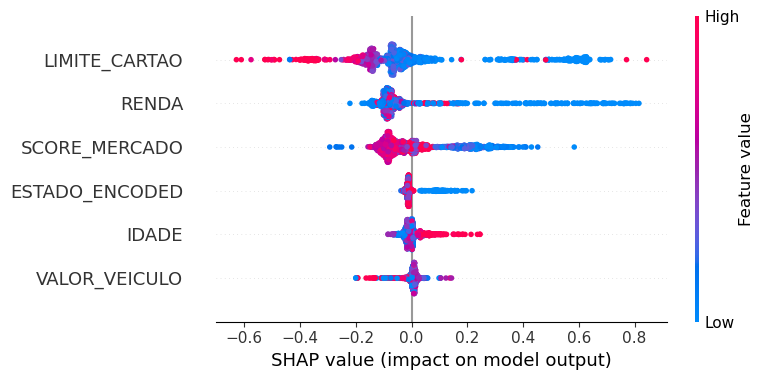

In [81]:
shap.summary_plot(shap_values, X_test)

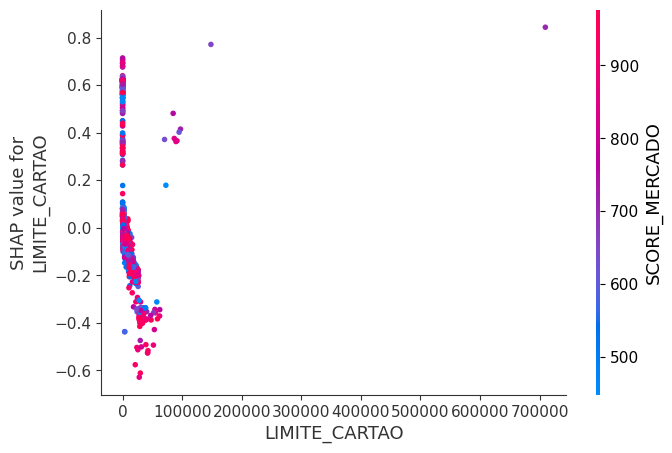

In [82]:
shap.dependence_plot("LIMITE_CARTAO", shap_values, X_test)


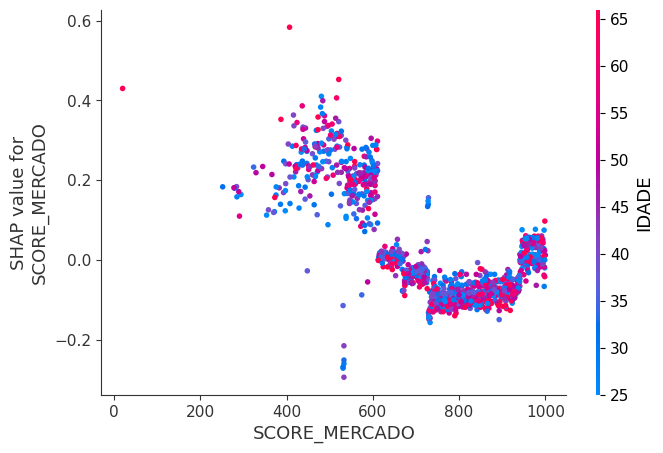

In [83]:
shap.dependence_plot("SCORE_MERCADO", shap_values, X_test)


## 4 - Conclusões

1. Uma dúvida que seria interessante esclarecer para a análise deste projeto seria a importância da variável Valor de financiamento atual, pois se muitos valores estavam com 0, isso quer dizer erro na coleta e preparação dos dados, ou alguma outra conclusão? (financiamento de outro produto, por exemplo, ou apenas aprovação para financiamento)

2. O perfil típico de clientes que tiveram o financiamento aprovado são pessoas do Estado de SP, em sua maioria, com idades mais frequentes de: 27, 26, 29, 28 e 45 anos (as 5 mais frequentes), com renda média de: 8213 reais. Como vimos na análise exploratória, rendas maiores e limites de cartão maiores podem implicar em um cliente possível de atrasar. Com relação ao score dos clientes, tanto clientes com score baixo, quanto altos, podem ser inadimplentes. 

3. A variável TARGET_M3OVER30 possui muito mais valores classificados como clientes que não atrasaram (0), do que clientes que atrasaram o financiamento (1). Isso indica que há muito mais pagadores do que não pagadores, e isso é ótimo, porém, para um modelo de Machine Learning, quando há um grande desbalanceamento de classes dessa forma, ele apresenta muito mais dificuldade em classificar de forma correta valores da classe 1 do que da classe 0. Isso fez com que a dificuldade em obter bons desempenhos dos modelos foi aumentada. 

4. Para tratamento e limpeza dos dados, precisei excluir alguns valores nulos, para não impactarem futuramente o modelo, exclui a coluna de valor de financiamento atual devido à grande quantidade de valores 0, além de que, precisei transformar algumas colunas em numéricas, pois estavam como object. Além disso, também transformei com datetime a coluna data de financiamento para poder obter informações do tempo de financiamento, ano e mês. Por fim, transformei a coluna estado com o label encoder para numérica seguindo a ordem alfabética dos estados. 

5. Como visto no notebook, utilizei vários algoritmos de classificação para este problema de risco de crédito. Para validar o modelo, utilizei classification report, matriz de confusão, análise de threshold, curva ROC AUC e curva precision-recall. A principal métrica analisada em todos os modelos foi o recall, pois, no caso de risco de crédito, a maior preocupação está nos falsos negativos — situações em que o modelo prevê que alguém irá pagar o financiamento, mas, na realidade, não pagará. Esse erro pode resultar em prejuízo financeiro significativo. Embora a precisão também seja importante, ela é menos crítica neste contexto. Se o modelo classificar erroneamente um cliente como mau pagador (falso positivo), quando na verdade ele é um bom pagador, o impacto é diferente e mais difícil de mensurar em termos de perdas financeiras. 

6. Com o shap values e a análise de feature importância do random forest, consegui identificar que as principais variáveis do modelo foram Renda e Limite do Cartão. Ambas possuem um grande impacto em todos os modelos analisados. 

7. Por fim, o modelo que apresentou o melhor desempenho (se olharmos somente para o recall) foi o Light GBM, que após testar várias técnicas de otimização, conseguimos alcançar um valor de recall de 0.78. O segundo modelo com melhor desempenho do recall foi o XGBoost, com recall de 0.67. Porém, os resultados, de um modo geral, mostram que mesmo com todo tratamento dos dados e a utilização de técnicas avançadas de modelagem, ainda assim não é uma tarefa simples separar as classes desbalanceadas de 0 e 1. 